In [2]:
import pandas as pd
import seaborn as sns
import sqlite3

In [3]:
cnx = sqlite3.connect('28sep.db')
df = pd.read_sql_query('SELECT * FROM battles', cnx)
df['date'] = pd.to_datetime(df.date).dt.tz_convert('Asia/Tehran')
df['hour'] = df.date.dt.hour
df['day'] = df.date.dt.day_name()

In [60]:
df

,id,duration,result,myRating,theirRating,myRatingChange,theirName,date,hour,day
0,1,48.834,VICTORY!,326681,167876,29,Felix_culpa,2024-09-28 00:11:24.131000+03:30,0,Saturday
1,2,66.635,DEFEAT!,326650,107035,-31,Lucky_beggar_D,2024-09-28 00:12:34.575000+03:30,0,Saturday
2,3,60.357,VICTORY!,326678,4630,28,Davitil884,2024-09-28 00:13:39.265000+03:30,0,Saturday
3,4,49.684,VICTORY!,326709,4311,31,Denik1981,2024-09-28 00:14:30.563000+03:30,0,Saturday
4,5,43.108,VICTORY!,326737,3855,28,Zenderpagany,2024-09-28 00:15:15.548000+03:30,0,Saturday
...,...,...,...,...,...,...,...,...,...,...
611,612,68.384,VICTORY!,332286,34993,29,Jp_171,2024-09-28 08:09:08.628000+03:30,8,Saturday
612,613,44.886,VICTORY!,332317,63065,31,San4ellllos,2024-09-28 08:09:55.289000+03:30,8,Saturday
613,614,127.490,VICTORY!,332378,16689,31,edgartkd,2024-09-28 08:13:20.904000+03:30,8,Saturday
614,615,30.620,DEFEAT!,332347,252908,-31,Slavonians,2024-09-28 08:13:55.941000+03:30,8,Saturday


In [5]:
df['resultBin'] = df['result'].map({
    'VICTORY!':1,
    'DEFEAT!':-1
})

6.0


<Axes: >

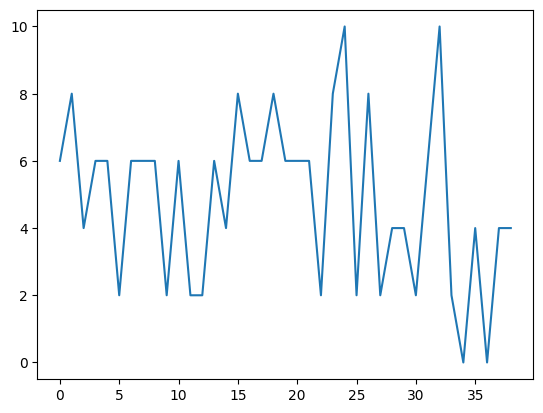

In [49]:
period = 16
print(df['resultBin'].groupby(df.index // period).sum().median())
df['resultBin'].groupby(df.index // period).sum().plot()

<Axes: >

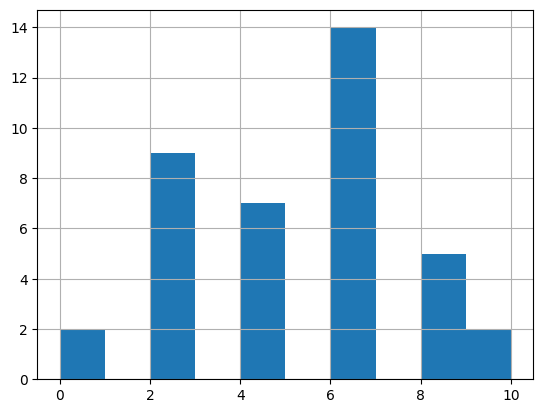

In [50]:
df['resultBin'].groupby(df.index // period).sum().hist()

In [76]:
df_counts = df.groupby(['theirName', 'result']).size().unstack(fill_value=0)
df_counts['timesPlayedThem'] = df_counts.sum(axis=1)
# df_counts['myRatingChangeSum'] = df.groupby(['theirName'])['myRatingChange'].sum()
df_counts.sort_values('timesPlayedThem', ascending=False).reset_index()

result,theirName,DEFEAT!,VICTORY!,timesPlayedThem
0,CENTR4LL,56,0,56
1,Felix_culpa,1,44,45
2,burak4040k,5,2,7
3,seinfy,6,0,6
4,PS_DZ,6,0,6
...,...,...,...,...
259,AH_1378h,0,1,1
260,Ridyto,0,1,1
261,Romsnoff,0,1,1
262,Sabermoghofei,0,1,1


In [79]:
df_opponents = df.merge(df_counts, on='theirName', how='left')
df_opponents

,id,duration,result,myRating,theirRating,myRatingChange,theirName,date,hour,day,DEFEAT!,VICTORY!,timesPlayedThem
0,1,48.834,VICTORY!,326681,167876,29,Felix_culpa,2024-09-28 00:11:24.131000+03:30,0,Saturday,1,44,45
1,2,66.635,DEFEAT!,326650,107035,-31,Lucky_beggar_D,2024-09-28 00:12:34.575000+03:30,0,Saturday,1,0,1
2,3,60.357,VICTORY!,326678,4630,28,Davitil884,2024-09-28 00:13:39.265000+03:30,0,Saturday,0,2,2
3,4,49.684,VICTORY!,326709,4311,31,Denik1981,2024-09-28 00:14:30.563000+03:30,0,Saturday,0,2,2
4,5,43.108,VICTORY!,326737,3855,28,Zenderpagany,2024-09-28 00:15:15.548000+03:30,0,Saturday,0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
611,612,68.384,VICTORY!,332286,34993,29,Jp_171,2024-09-28 08:09:08.628000+03:30,8,Saturday,0,1,1
612,613,44.886,VICTORY!,332317,63065,31,San4ellllos,2024-09-28 08:09:55.289000+03:30,8,Saturday,0,4,4
613,614,127.490,VICTORY!,332378,16689,31,edgartkd,2024-09-28 08:13:20.904000+03:30,8,Saturday,0,3,3
614,615,30.620,DEFEAT!,332347,252908,-31,Slavonians,2024-09-28 08:13:55.941000+03:30,8,Saturday,3,0,3


<Axes: xlabel='date', ylabel='myRating'>

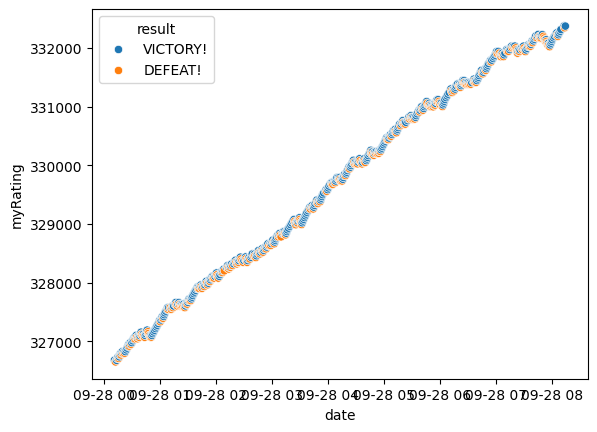

In [80]:
sns.scatterplot(df_opponents, x = 'date', y = 'myRating', hue = 'result')

<Axes: xlabel='date'>

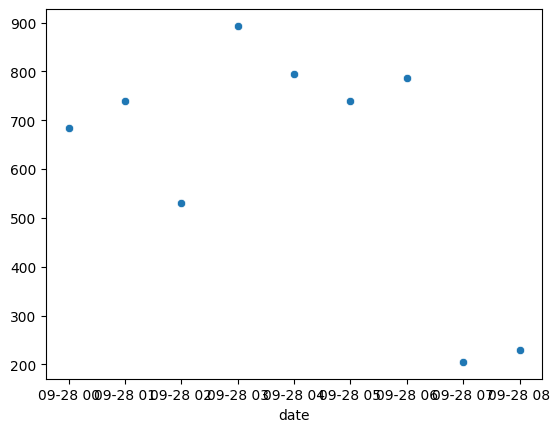

In [81]:
dv = 'myRatingChange'
period = '1h'
df_resample = df_opponents.resample(period, on='date')[dv].sum()
sns.scatterplot(x = df_resample.index, y = df_resample.values)

Text(0.5, 1.0, 'Change in rating / hour')

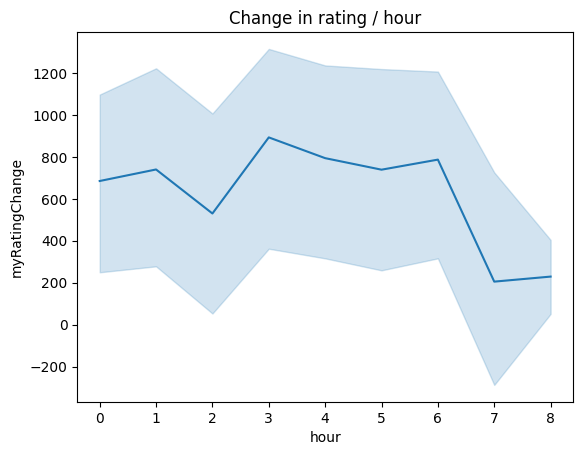

In [82]:
ax = sns.lineplot(df_opponents, x = 'hour', y = 'myRatingChange', estimator='sum')
ax.set_title('Change in rating / hour')

Text(0.5, 1.0, '')

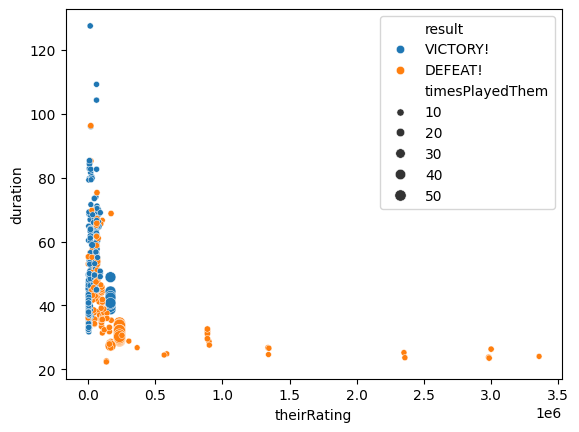

In [84]:
ax = sns.scatterplot(df_opponents, x = 'theirRating', y = 'duration', hue='result', size='timesPlayedThem')
ax.set_title('')

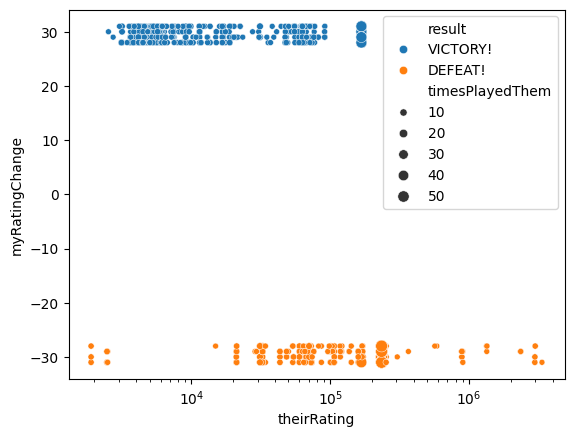

In [87]:
ax = sns.scatterplot(df_opponents, x = 'theirRating', y = 'myRatingChange', hue='result', size='timesPlayedThem')
ax.set_title('')
ax.set_xscale('log')

<Axes: xlabel='timesPlayedThem', ylabel='theirRating'>

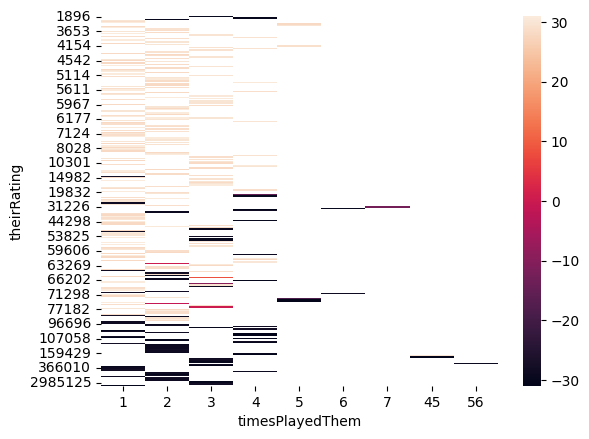

In [91]:
pivot = pd.pivot_table(df_opponents, index = 'theirRating', columns='timesPlayedThem', values='myRatingChange', aggfunc='mean')
sns.heatmap(pivot, )

<Axes: xlabel='timesPlayedThem', ylabel='theirRating'>

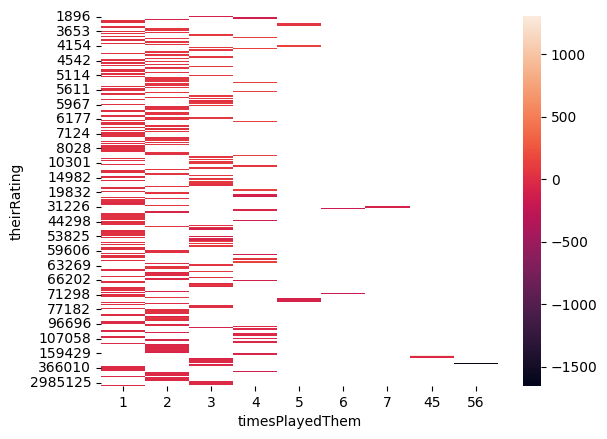

In [93]:
pivot = pd.pivot_table(df_opponents, index = 'theirRating', columns='timesPlayedThem', values='myRatingChange', aggfunc='sum')
sns.heatmap(pivot, )

In [111]:
myRatingChange = df_opponents.groupby('theirName')['myRatingChange'].sum()
myRatingChange.name = 'myRatingChangeSum'
df_opponents_sum = df_opponents.merge(myRatingChange, on='theirName')

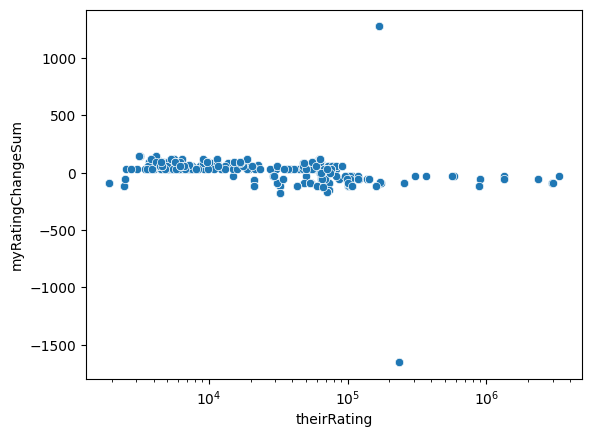

In [112]:
ax = sns.scatterplot(df_opponents_sum, x='theirRating', y='myRatingChangeSum')
ax.set_xscale('log')


<Axes: xlabel='date', ylabel='theirRating'>

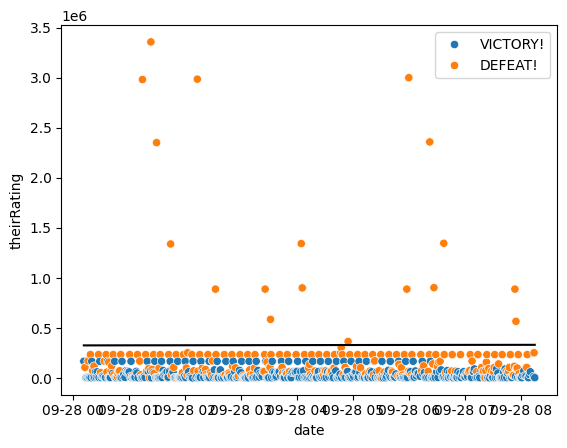

In [121]:
ax = sns.scatterplot(df_opponents_sum, x='date', y='theirRating', hue='result')
sns.lineplot(df_opponents_sum, x='date', y='myRating', ax=ax, color='black' )

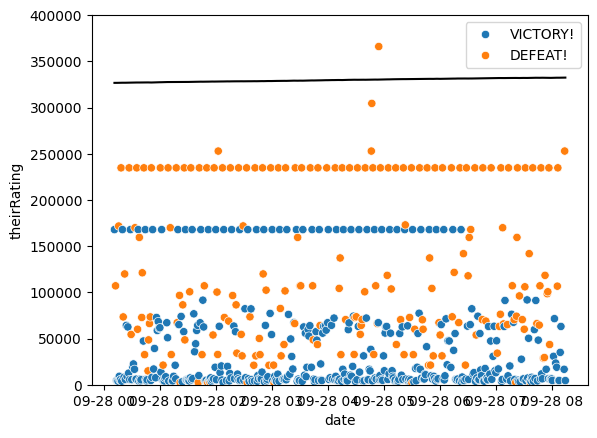

In [122]:
ax = sns.scatterplot(df_opponents_sum, x='date', y='theirRating', hue='result')
sns.lineplot(df_opponents_sum, x='date', y='myRating', ax=ax, color='black' )
ax.set_ybound(0, 400_000)

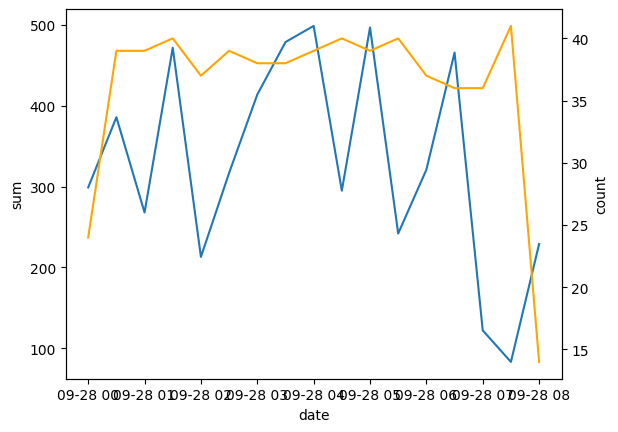

In [153]:
df_10mins = df_opponents_sum.resample('30min', on='date')['myRatingChange'].agg(['sum', 'count'])
ax = sns.lineplot(df_10mins['sum'])
ax2 = ax.twinx()
ax = sns.lineplot(df_10mins['count'], color='orange', markers='--',ax=ax2)

In [148]:
hourly = df_opponents_sum.resample('30min', on='date')['myRatingChange', 'theirRating'].agg(['sum', 'mean'])
hourly

myRatingChange            theirRating               
                                     sum       mean         sum           mean
date                                                                          
2024-09-28 00:00:00+03:30            299  12.458333     1703753   70989.708333
2024-09-28 00:30:00+03:30            386   9.897436     2522256   64673.230769
2024-09-28 01:00:00+03:30            268   6.871795    11138807  285610.435897
2024-09-28 01:30:00+03:30            472  11.800000     3693901   92347.525000
2024-09-28 02:00:00+03:30            213   5.756757     5675720  153397.837838
2024-09-28 02:30:00+03:30            317   8.128205     3250237   83339.410256
2024-09-28 03:00:00+03:30            414  10.894737     3117508   82039.684211
2024-09-28 03:30:00+03:30            479  12.605263     3327374   87562.473684
2024-09-28 04:00:00+03:30            499  12.794872     4550232  116672.615385
2024-09-28 04:30:00+03:30            295   7.375000     3519463   87986.575000
2024-09-28 05:00:00+03:30            497  12.743590     2603280   66750.769231
2024-09-28 05:30:00+03:30            242   6.050000     6194756  154868.900000
2024-09-28 06:00:00+03:30            321   8.675676     5710547  154339.108108
2024-09-28 06:30:00+03:30            466  12.944444     3325272   92368.666667
2024-09-28 07:00:00+03:30            122   3.388889     2241374   62260.388889
2024-09-28 07:30:00+03:30             83   2.024390     3816481   93084.902439
2024-09-28 08:00:00+03:30            229  16.357143      871802   62271.571429

In [149]:
hourly['myRatingChange']['sum'].median()

317.0